# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import trange
%matplotlib inline

import sys
sys.path.append('C:\\Users\\lucai\\nuvPriors_repo\\nuvPriors')
from src.models.rtbModel import RTBModel

# Data Generation

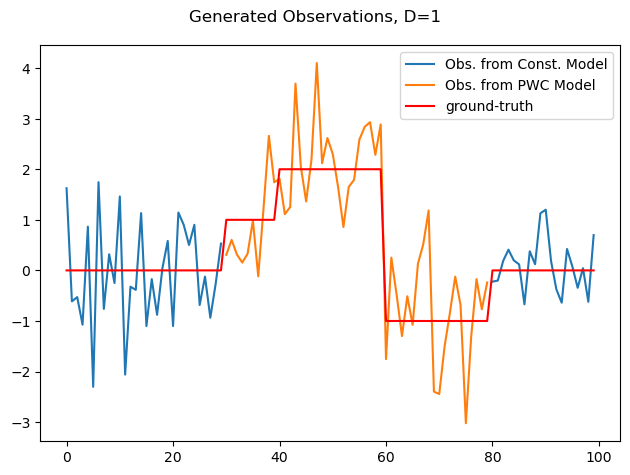

In [2]:
# Specify Parameters
N = 100
M = 2
D = 1
varNoise = 1.0
covNoise = np.tile(np.identity(D, dtype=float)*varNoise, (N,1,1))
seed = 1
np.random.seed(seed)

# Specify model indices
selectedModel = np.concatenate(
    (np.zeros(int(0.3*N), dtype=int), 
     np.ones(int(0.5*N), dtype=int), 
     np.zeros(int(0.2*N), dtype=int)), 
    axis=0)

# Specify levels
x_m0 = np.zeros((N,D), dtype=float)
x_m1 = np.concatenate(
    (np.ones((int(0.4*N),D), dtype=int)*1.0, 
     np.ones((int(0.2*N),D), dtype=int)*2.0, 
     np.ones((int(0.4*N),D), dtype=int)*-1.0), 
    axis=0)
x_allModels = np.concatenate((x_m0[:,np.newaxis,:], x_m1[:,np.newaxis,:]), axis=1)

# Calculate X and Y
x = np.array([x_allModels[i,selectedModel_i] for i, selectedModel_i in zip (range(N), selectedModel)])
y = np.array([np.random.multivariate_normal(x_i, covNoise_i) for x_i, covNoise_i in zip(x, covNoise)])

# Plot data
fig1, axs1 = plt.subplots()

y_m0 = np.where(selectedModel[:,np.newaxis]==0, y, np.nan)
y_m1 = np.where(selectedModel[:,np.newaxis]==1, y, np.nan)
axs1.plot(y_m0, label='Obs. from Const. Model')
axs1.plot(y_m1, label='Obs. from PWC Model')
axs1.plot(x, c='r', label='ground-truth')
axs1.legend()

fig1.suptitle(f'Generated Observations, D={D}')
fig1.tight_layout()

# Estimation

  2%|█▍                                                                              | 18/1000 [00:01<00:54, 17.90it/s]


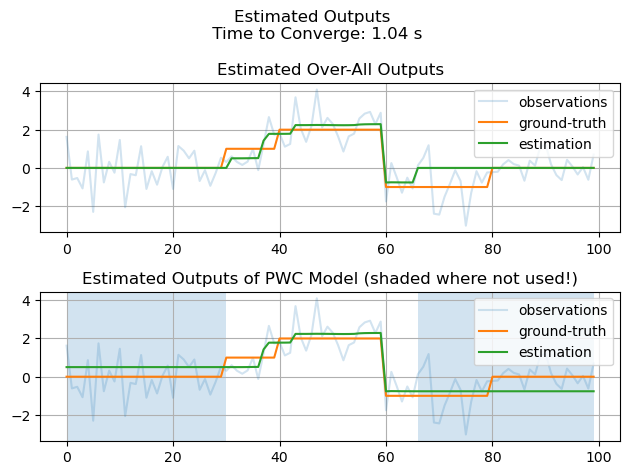

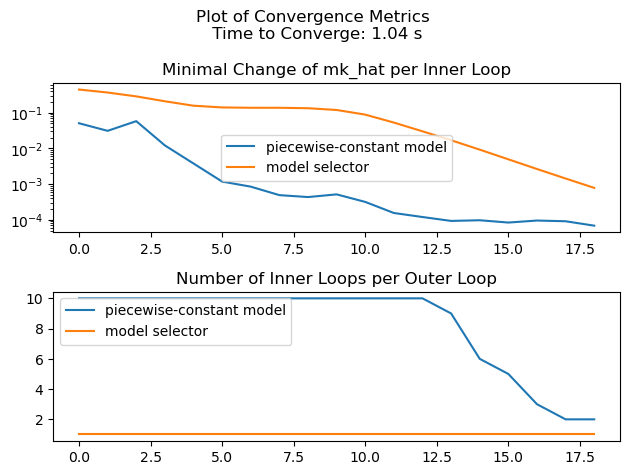

In [3]:
# Construct sigmas (i.e., assumed observation noise per model) and base level
sigmas = np.array([np.identity(D, dtype=float)*2.0, np.identity(D, dtype=float)*1.0])
constLevel = np.zeros((1,1), dtype=float)

########################################################################################################################

# Initialize estimator
estimator = RTBModel(N=N, D=D, constLevel=constLevel, sigmas=sigmas)

# Do estimation
performanceMetrics, i_it_outer, conv_time = estimator.estimate_output(y=y, n_it_irls_x=10, n_it_irls_s=1)

########################################################################################################################

# Get estimates
ms_hat, _ = estimator.get_sHat()
selectedModel = np.argmax(ms_hat, axis=1)
mx_hat, _ = estimator.get_xHat()
output = estimator.get_output()

# Plot estimations
fig2, axs2 = plt.subplots(2,1)

axs2[0].plot(y, alpha=0.2, label='observations')
axs2[0].plot(x, label='ground-truth')
axs2[0].plot(output, label='estimation')
axs2[0].legend()
axs2[0].set_title('Estimated Over-All Outputs')
axs2[0].grid()

axs2[1].plot(y, alpha=0.2, label='observations')
axs2[1].plot(x, label='ground-truth')
axs2[1].plot(mx_hat, label='estimation')
axs2[1].fill_between(np.where(selectedModel==0, np.arange(N), np.nan), np.ones(N)*-1e3, np.ones(N)*1e3, alpha=0.2)
axs2[1].set_ylim(axs2[0].get_ylim())
axs2[1].legend()
axs2[1].set_title('Estimated Outputs of PWC Model (shaded where not used!)')
axs2[1].grid()

fig2.suptitle(f'Estimated Outputs \n Time to Converge: {round(conv_time, 2)} s')
fig2.tight_layout()

########################################################################################################################

fig3, axs3 = plt.subplots(2,1)

axs3[0].plot(performanceMetrics['change_x_min'])
axs3[0].plot(performanceMetrics['diffAZOSol_s'])
axs3[0].set_yscale('log')
axs3[0].legend(['piecewise-constant model', 'model selector'])
axs3[0].set_title('Minimal Change of mk_hat per Inner Loop')

axs3[1].plot(performanceMetrics['i_it_x']+1)
axs3[1].plot(performanceMetrics['i_it_s']+1)
axs3[1].legend(['piecewise-constant model', 'model selector'])
axs3[1].set_title('Number of Inner Loops per Outer Loop')

fig3.suptitle(
    f'Plot of Convergence Metrics \n Time to Converge: {round(conv_time, 2)} s')
fig3.tight_layout()